In [ ]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 34.0 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/Assignment4/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! mkdir /content/drive/MyDrive/Assignment4/data

In [ ]:
! kaggle competitions download challenges-in-representation-learning-facial-expression-recognition-challenge

challenges-in-representation-learning-facial-expression-recognition-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip -d /content/drive/MyDrive/Assignment4/data

Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: /content/drive/MyDrive/Assignment4/data/example_submission.csv  
  inflating: /content/drive/MyDrive/Assignment4/data/fer2013.tar.gz  
  inflating: /content/drive/MyDrive/Assignment4/data/icml_face_data.csv  
  inflating: /content/drive/MyDrive/Assignment4/data/test.csv  
  inflating: /content/drive/MyDrive/Assignment4/data/train.csv  


In [ ]:
import tarfile

with tarfile.open('/content/drive/MyDrive/Assignment4/data/fer2013.tar.gz', 'r:gz') as tar:
    tar.extractall('/content/drive/MyDrive/Assignment4/data/')

✅ fer2013.tar.gz extracted!


In [ ]:
!rm /content/drive/MyDrive/Assignment4/data/fer2013.tar.gz

**რადგან მონაცემები გავამზადეთ ახლა თვალი შევავლოთ მათ**

In [ ]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

#copied from Animal_Faces_Pytorch.ipynb

Device available:  cuda


In [ ]:
fer2013=pd.read_csv('/content/drive/MyDrive/Assignment4/data/fer2013/fer2013.csv')

In [ ]:
print(fer2013.columns)

Index(['emotion', 'pixels', 'Usage'], dtype='object')


In [ ]:
print(fer2013['Usage'])
print(fer2013['Usage'].value_counts())

In [ ]:
train=fer2013[fer2013['Usage']=='Training']
train=train.drop('Usage',axis=1)

val=fer2013[fer2013['Usage']=='PrivateTest']
val=val.drop('Usage',axis=1)

test=fer2013[fer2013['Usage']=='PublicTest']
test=test.drop('Usage',axis=1)

Y_test_fin=test['emotion']
X_test_fin=test.drop('emotion',axis=1)

In [ ]:
emotion_labels ={
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

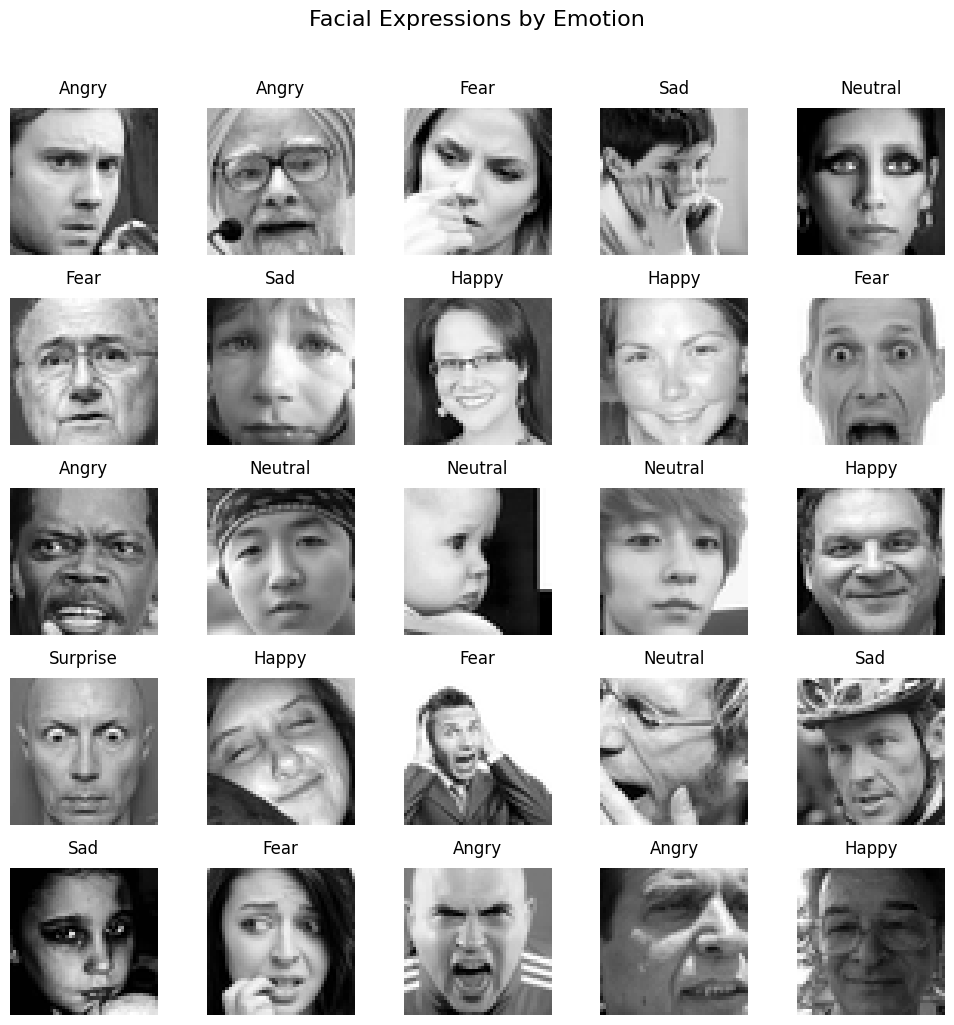

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


sample_indices = range(25)
pixel_data = [train['pixels'][i].split() for i in sample_indices]
emotion_data = [train['emotion'][i] for i in sample_indices]

images = [np.array(pixels, dtype=np.uint8).reshape(48, 48) for pixels in pixel_data]

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
fig.suptitle("Facial Expressions by Emotion", fontsize=16, y=1.02)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')
    ax.axis('off')
    emotion_num = emotion_data[i]
    emotion_name = emotion_labels.get(emotion_num, f"Unknown ({emotion_num})")
    ax.set_title(f"{emotion_name}", pad=10)

plt.tight_layout()
plt.show()

**როგორც ვხედავთ მონაცემები შეიცავს 48x48-ზე შავ-თეთრ ფოტოებს, რომლებსაც მოყვება შესაბამისი ემოციის label. მონაცემები დაყოფილია სამ ნაწილად, ესენია: Training (რითიც გავწვრთნით მოდელს), PrivateTest (ანუ validation სეტი) და PublicTest (ანუ რითიც დავაგენერირებთ საბმიშენს)**


* ფოტოებიდან გამომდინარე მარტივი შესამჩნევია რომ ისინი შეიცავს ხმაურს